In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## data set の読み込み
- github large file system (lfs) を使用
- resize された写真を用意する
  - colab 側でリサイズする大きさは制御したほうがいい？


In [ ]:
!sudo apt install git-lfs
!git lfs version
!rm -rf ml
!mkdir ml
!cd ml
!git init
!git lfs install
!git clone https://github.com/kokoichi206/ml.git
!git fetch
!cd ..
!ls -la ml/akimoto/
!mv ml/akimoto/saka.zip saka.zip
!mv ml/akimoto/akb.zip akb.zip

!rm -rf akb_pre
!rm -rf saka_pre

!ls
!yes | unzip akb.zip > /dev/null
!yes | unzip saka.zip > /dev/null

!ls akb_pre | wc
!ls saka_pre | wc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (19.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155222 files and directories cu

In [ ]:
!ls akb_pre | wc
!ls saka_pre | wc

   3847    3847   42325
   3928    3928   43216


In [ ]:
from PIL import Image
import numpy as np
import glob
import gc


groups = ["akb", "saka"]

akbs = glob.glob("akb_pre/*.jpg")
sakas = glob.glob("saka_pre/*.jpg")
faces = []
cnt = 0

print(np.asarray(Image.open(akbs[0]), np.uint8).shape)


for path in akbs:
    cnt += 1
    with Image.open(path) as img:
        # colabでリサイズする場合
        # orig = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

for path in sakas:
    cnt += 1
    with Image.open(path) as img:
        faces.append(np.asarray(img, np.uint8))

X = np.array(faces)
# 正解ラベルを作成する
len_akbs = len(akbs)
len_sakas = len(sakas)
y = np.zeros((len_akbs+len_sakas, 2))
for i in range(len_akbs):
    y[i, 0] = 1
for j in range(len(sakas)):
    y[j+len_akbs, 1] = 1

(128, 128, 3)


In [ ]:
print(X.shape)
print(y.shape)
print(X.shape[1])

(7775, 128, 128, 3)
(7775, 2)
128


## model の作成・訓練

In [ ]:
# model と weight をローカルに保存するための準備
version = "5th"
f_log = "./log"
f_models = "/content/drive/MyDrive/Colab Notebooks/akimoto/models"
model_filename = f"model_{version}.json"
weight_filename = f"weights_{version}.hdf5"

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers

IMG_SIZE = X.shape[1]
inputs = layers.Input((IMG_SIZE,IMG_SIZE,3))
## １層目
x = layers.Conv2D(64, 3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 2層目
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 3層目
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)

# # ## 4層目
# x = layers.Conv2D(512, 3, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(2, activation="softmax")(x)

model = tf.keras.models.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

In [ ]:
import os

json_string = model.to_json()
with open(os.path.join(f_models, model_filename), mode='w') as f:
    f.write(json_string)

In [ ]:
from sklearn.model_selection import train_test_split

def create_dataset(X, y, test_size=0.2, random_state=123):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train.astype(np.float32) / 255.0, X_test.astype(np.float32) / 255.0, y_train.astype(np.float32), y_test.astype(np.float32)

In [15]:
import matplotlib.pyplot as plt
import os

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 150
# seeds = [3, 123, 44, 77]
seeds = [77]
len_seeds = len(seeds)

train_losses = []
train_acces = []
val_losses = []
val_acces = []
# for seed in 
for i in range(len_seeds):
    X_train, X_test, y_train, y_test = create_dataset(X, y, random_state=seeds[i])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    train_losses += history.history['loss'] 
    train_acces += history.history['accuracy'] 
    val_losses += history.history['val_loss'] 
    val_acces += history.history['val_accuracy']

model.save_weights(os.path.join(f_models, weight_filename))

Epoch 1/150
25/25 [==============================] - 27s 540ms/step - loss: 0.7642 - accuracy: 0.5585 - val_loss: 0.6891 - val_accuracy: 0.5228
Epoch 2/150
25/25 [==============================] - 12s 477ms/step - loss: 0.6638 - accuracy: 0.5968 - val_loss: 0.6921 - val_accuracy: 0.5293
Epoch 3/150
25/25 [==============================] - 11s 460ms/step - loss: 0.6520 - accuracy: 0.6084 - val_loss: 0.6973 - val_accuracy: 0.4997
Epoch 4/150
25/25 [==============================] - 12s 476ms/step - loss: 0.6470 - accuracy: 0.6199 - val_loss: 0.7288 - val_accuracy: 0.4482
Epoch 5/150
25/25 [==============================] - 12s 462ms/step - loss: 0.6410 - accuracy: 0.6309 - val_loss: 0.7037 - val_accuracy: 0.4688
Epoch 6/150
25/25 [==============================] - 11s 459ms/step - loss: 0.6325 - accuracy: 0.6452 - val_loss: 0.7648 - val_accuracy: 0.4945
Epoch 7/150
25/25 [==============================] - 11s 459ms/step - loss: 0.6388 - accuracy: 0.6344 - val_loss: 0.7561 - val_accuracy:

In [16]:
from keras.models import model_from_json

json_string = open(os.path.join(f_models, model_filename)).read()
model = model_from_json(json_string)

model.summary()

# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.5), metrics=['accuracy'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.load_weights(os.path.join(f_models, weight_filename))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

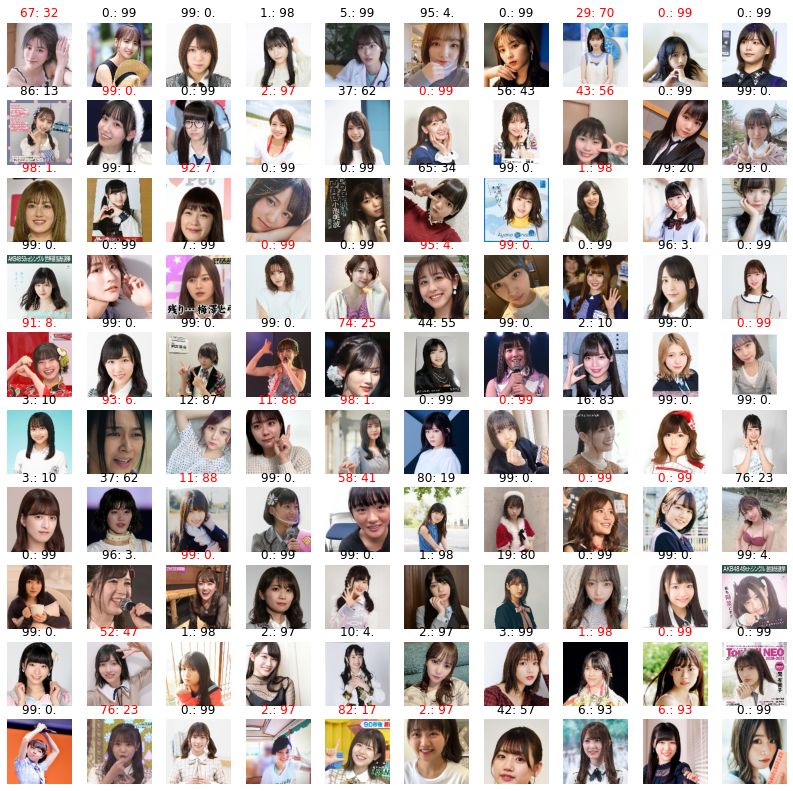

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,14))
y_raw = model.predict(X_test)
y_pred = np.argmax(y_raw, axis=-1) # argmaxでラベルを取る
y_correct = np.argmax(y_test, axis=-1)

for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(X_test[i])
    ax.axis("off")

    akb_percentage = str(100*y_raw[i][0])[:2]
    saka_percentage = str(100*y_raw[i][1])[:2]
    if y_pred[i] == y_correct[i]:
        ax.set_title(f"{akb_percentage}: {saka_percentage}")
    else:
        ax.set_title(f"{akb_percentage}: {saka_percentage}", color="red")


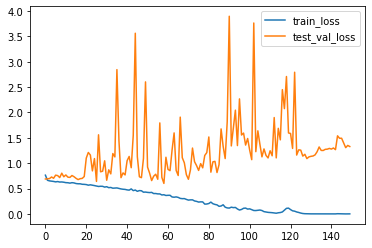

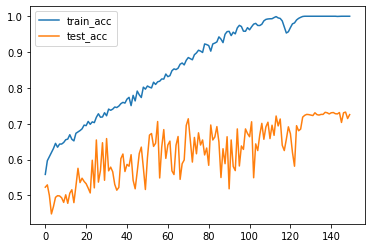

In [18]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_losses)), train_losses, label='train_loss')
plt.plot(np.arange(len(val_losses)), val_losses, label='test_val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acces)), train_acces, label='train_acc')
plt.plot(np.arange(len(val_acces)), val_acces, label='test_acc')
plt.legend()
plt.show()